# **Import Library 📚**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import pickle
import optuna
import tqdm


c:\Users\LEGION\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **Importing Data ⬇️**

In [2]:
data = pd.read_csv('data_encoded.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   datetime           304 non-null    object 
 1   temperature        304 non-null    float64
 2   dew_point          304 non-null    float64
 3   relative_humidity  304 non-null    float64
 4   wind_speed         304 non-null    float64
 5   precipitation      304 non-null    float64
 6   cloud_cover        304 non-null    float64
 7   conditions_enc     304 non-null    int64  
 8   value              304 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 21.5+ KB


# **Feature Engineering 🪛**

## *Handling Outliers*

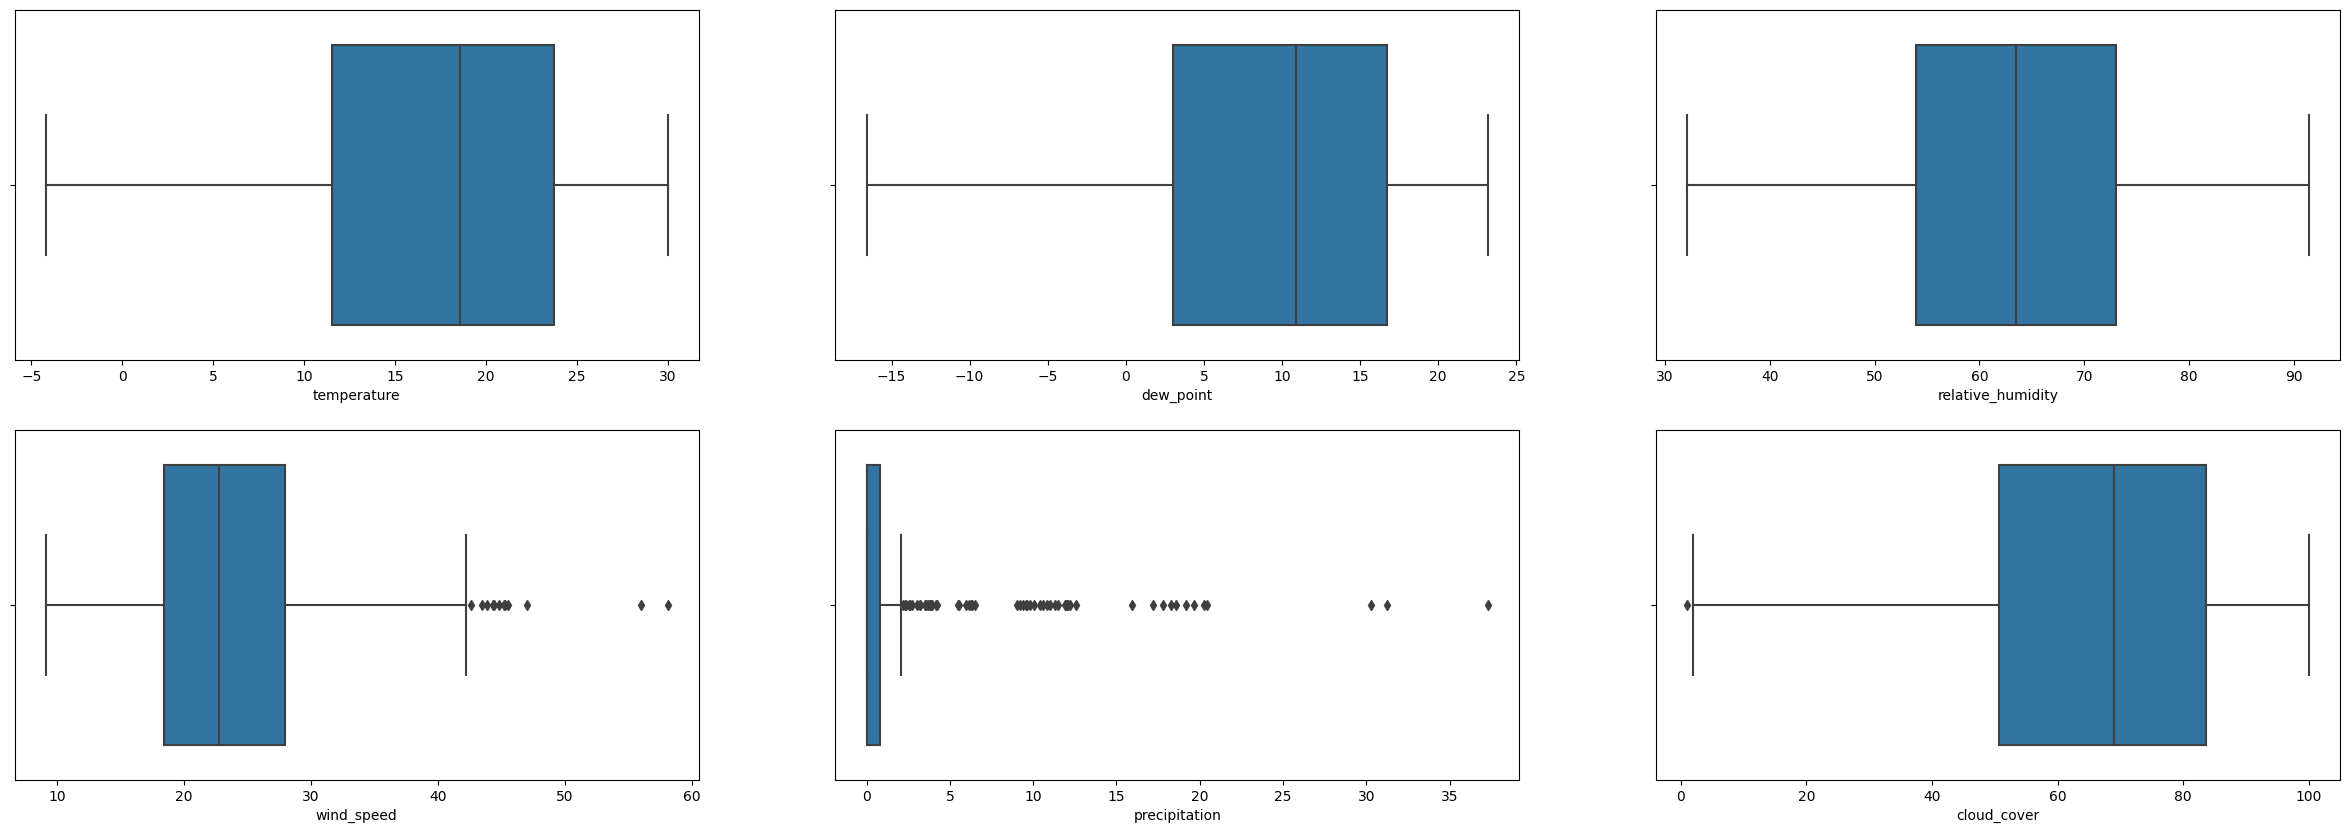

In [4]:
# Identify numeric columns excluding datetime and value columns
features_col = data.select_dtypes(include=['number']).columns
features_col = [col for col in features_col if col not in ['datetime', 'value', 'conditions_enc']]

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(30, 10))
axes = axes.flatten()

# Iterate over numeric columns
for i, column in enumerate(features_col):
    # Create boxplot only if the column is numeric
    sns.boxplot(x=data[column], ax=axes[i])

# Display the plots
plt.show()

In [5]:
# Remove outliers
for column in features_col:
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    fence_low = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    data = data.loc[(data[column] > fence_low) & (data[column] < fence_high)]

# Display the modified data
data

,datetime,temperature,dew_point,relative_humidity,wind_speed,precipitation,cloud_cover,conditions_enc,value
0,2023-01-01,11.0,7.9,82.24,14.2,0.10,47.7,3,182.636277
1,2023-01-02,10.5,6.8,79.25,14.7,0.00,87.8,2,182.636277
2,2023-01-03,15.1,11.3,78.49,28.5,0.00,90.7,2,182.636277
3,2023-01-04,15.3,12.8,85.43,22.8,0.00,85.1,2,182.636277
4,2023-01-05,13.5,7.8,70.43,20.2,0.00,75.8,2,182.636277
...,...,...,...,...,...,...,...,...,...
299,2023-10-27,20.3,14.8,72.70,15.7,0.00,66.5,1,167.770644
300,2023-10-28,21.7,15.5,70.61,16.2,0.00,50.1,1,167.770644
301,2023-10-29,20.7,16.5,77.37,17.2,0.99,90.2,4,167.770644
302,2023-10-30,17.1,12.7,75.93,36.5,0.89,79.8,4,167.770644


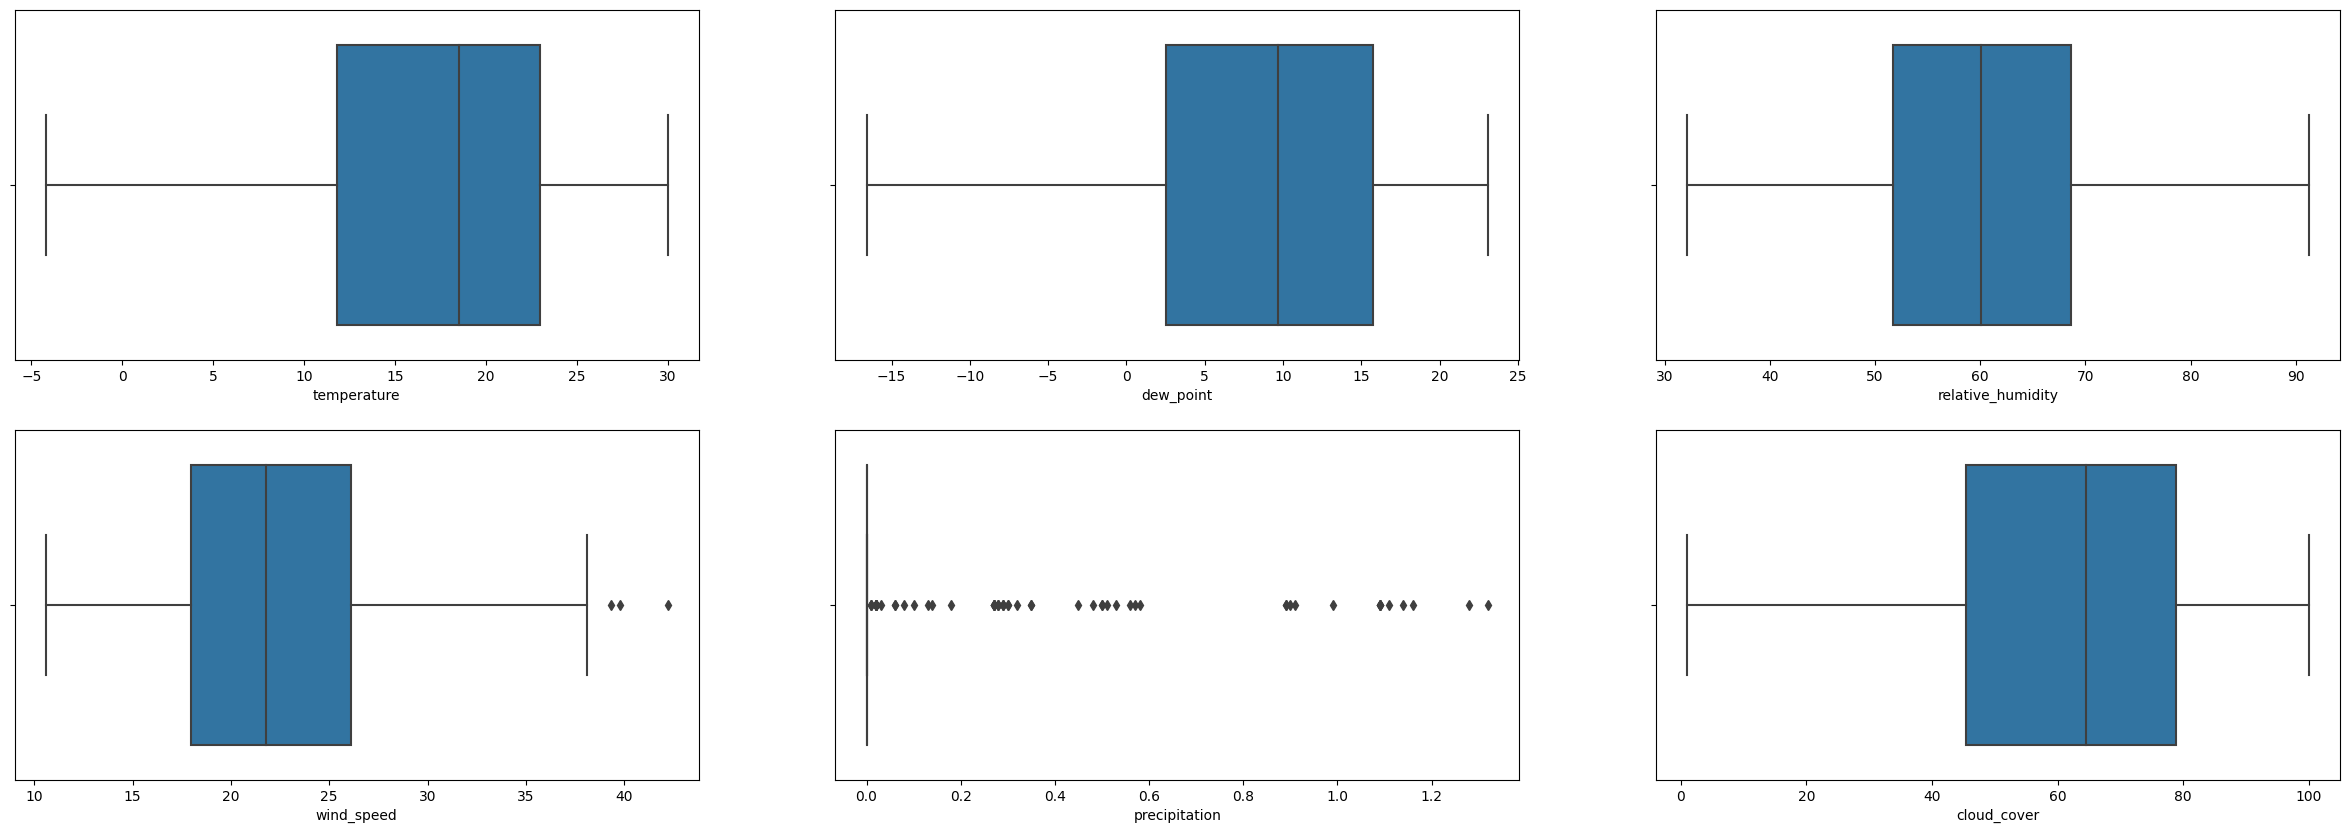

In [6]:
# Identify numeric columns excluding datetime and value columns
features_col = data.select_dtypes(include=['number']).columns
features_col = [col for col in features_col if col not in ['datetime', 'value', 'conditions_enc']]

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(30, 10))
axes = axes.flatten()

# Iterate over numeric columns
for i, column in enumerate(features_col):
    # Create boxplot only if the column is numeric
    sns.boxplot(x=data[column], ax=axes[i])

# Display the plots
plt.show()

## *Dropping Column*

In [7]:
data.drop('precipitation', axis=1, inplace=True)
data

,datetime,temperature,dew_point,relative_humidity,wind_speed,cloud_cover,conditions_enc,value
0,2023-01-01,11.0,7.9,82.24,14.2,47.7,3,182.636277
1,2023-01-02,10.5,6.8,79.25,14.7,87.8,2,182.636277
2,2023-01-03,15.1,11.3,78.49,28.5,90.7,2,182.636277
3,2023-01-04,15.3,12.8,85.43,22.8,85.1,2,182.636277
4,2023-01-05,13.5,7.8,70.43,20.2,75.8,2,182.636277
...,...,...,...,...,...,...,...,...
299,2023-10-27,20.3,14.8,72.70,15.7,66.5,1,167.770644
300,2023-10-28,21.7,15.5,70.61,16.2,50.1,1,167.770644
301,2023-10-29,20.7,16.5,77.37,17.2,90.2,4,167.770644
302,2023-10-30,17.1,12.7,75.93,36.5,79.8,4,167.770644


## *Getting month from datetime*

In [8]:
data['datetime'] = pd.to_datetime(data['datetime'])
data['month'] = data['datetime'].dt.month

# make value column as the last column

cols = list(data.columns.values)  # Make a list of all of the columns in the df
cols.pop(cols.index('value'))  # Remove value from list
data = data[cols + ['value']] 

In [9]:
data

,datetime,temperature,dew_point,relative_humidity,wind_speed,cloud_cover,conditions_enc,month,value
0,2023-01-01,11.0,7.9,82.24,14.2,47.7,3,1,182.636277
1,2023-01-02,10.5,6.8,79.25,14.7,87.8,2,1,182.636277
2,2023-01-03,15.1,11.3,78.49,28.5,90.7,2,1,182.636277
3,2023-01-04,15.3,12.8,85.43,22.8,85.1,2,1,182.636277
4,2023-01-05,13.5,7.8,70.43,20.2,75.8,2,1,182.636277
...,...,...,...,...,...,...,...,...,...
299,2023-10-27,20.3,14.8,72.70,15.7,66.5,1,10,167.770644
300,2023-10-28,21.7,15.5,70.61,16.2,50.1,1,10,167.770644
301,2023-10-29,20.7,16.5,77.37,17.2,90.2,4,10,167.770644
302,2023-10-30,17.1,12.7,75.93,36.5,79.8,4,10,167.770644


# **Splitting Data into train and test**

In [10]:
# Feature engineering
data['datetime'] = pd.to_datetime(data['datetime'])
data['month'] = data['datetime'].dt.month

# Data preprocessing
X = data.drop(['datetime', 'value'], axis=1)  # Features (excluding 'datetime')
y = data['value']  # Target

# Train-test split based on datetime
train_size = int(0.8 * len(data))
train, test = data[:train_size], data[train_size:]

# Creating a mapping dictionary for month-to-mean target value
monthly_mean_train = train.groupby('month')['value'].mean()
month_to_mean_train = dict(zip(monthly_mean_train.index, monthly_mean_train.values))

# Applying the mean target value for each month to the training set
train['month_mean'] = train['month'].map(month_to_mean_train)

# Applying the mean target value for each month to the test set with imputation for unseen months
test['month_mean'] = test['month'].map(month_to_mean_train)

# Impute missing values for months not seen in the training set
mean_target_value = train['value'].mean()
test['month_mean'].fillna(mean_target_value, inplace=True)

# Splitting into X_train, X_test, y_train, y_test
X_train, y_train = train.drop(['datetime', 'value'], axis=1), train['value']
X_test, y_test = test.drop(['datetime', 'value'], axis=1), test['value']

C:\Users\LEGION\AppData\Local\Temp\ipykernel_10088\3513061338.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['month_mean'] = train['month'].map(month_to_mean_train)
C:\Users\LEGION\AppData\Local\Temp\ipykernel_10088\3513061338.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['month_mean'] = test['month'].map(month_to_mean_train)
C:\Users\LEGION\AppData\Local\Temp\ipykernel_10088\3513061338.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame


# **Modelling 🤖** 

## *Linear Regression*

In [11]:
# linear Regression

model = LinearRegression()
model.fit(X_train, y_train)

# Model prediction
y_pred = model.predict(X_test)

# Evaluate the model using RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 1.6038656869311558


## *XGBoostRegressor*

In [12]:
# XGBoostRegressor

model = XGBRegressor()
model.fit(X_train, y_train)

# Model prediction
y_pred = model.predict(X_test)

# Evaluate the model using RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 0.6967647125331465


## *RandomForestRegressor*

In [13]:
# random forest regressor

model = RandomForestRegressor()
model.fit(X_train, y_train)

# Model prediction
y_pred = model.predict(X_test)

# Evaluate the model using RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 0.5406971579155787


## *DecTreeRegressor*

In [14]:
# decision tree regressor

model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# Model prediction
y_pred = model.predict(X_test)

# Evaluate the model using RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 0.6966229150727706


# **🔴END OF NOTEBOOK🔴**